In [1]:
#from auto_os_elm import AUTO_ELM   # Huang's algorithm
from auto_elm import AUTO_ELM   # Our proposed algorithm

import math
import numpy as np
import tensorflow as tf
#from tqdm import tqdm_notebook as tqdm # Jupyter notebook should use this
import matplotlib.pyplot as plt
import cv2



"""CIFAR10 dataset handler"""
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

"""CIFAR10 reshape to RGB image"""
def reshape_CIFAR(x):
    arr = x
    R = arr[0:1024].reshape(32,32)
    return R # in fact, it's a gray scale image
    #G = arr[1024:2048].reshape(32,32)
    #B = arr[2048:].reshape(32,32)
    #img = np.dstack((R,G,B))
    #return img
 

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_cifar10_batch(x_train, y_train, path):
    data_dict_train_batch = unpickle(path)
    x_train_batch = data_dict_train_batch[b'data']
    y_train_batch = data_dict_train_batch[b'labels']
    for i in range(len(x_train_batch)):
        gray = 0.3*x_train_batch[i][:1024]
        gray = 0.6*gray + x_train_batch[i][1024:2048]
        gray = 0.1*gray + x_train_batch[i][2048:]
        x_train.append(gray/255.)
        #x_train.append(x_train_batch[i]/255.)
        y_train.append(y_train_batch[i])
        
    return x_train, y_train

# I use gray-scale to train the ELM-based auto-encoder. 
# If we have a convolutional layer before the ELM, we can use RGB image to train
n_input_nodes = 32*32#*3
n_hidden_nodes = 256  # used to be 
n_output_nodes = 32*32#*3

n_classes = n_output_nodes

# ===========================================
# Prepare dataset
# ===========================================

x_train = []
y_train = []
x_train, y_train = load_cifar10_batch(x_train,y_train, 'cifar-10-batches-py/data_batch_1')
x_train, y_train = load_cifar10_batch(x_train,y_train, 'cifar-10-batches-py/data_batch_2')
x_train, y_train = load_cifar10_batch(x_train,y_train, 'cifar-10-batches-py/data_batch_3')
x_train, y_train = load_cifar10_batch(x_train,y_train, 'cifar-10-batches-py/data_batch_4')
x_train, y_train = load_cifar10_batch(x_train,y_train, 'cifar-10-batches-py/data_batch_5')
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
x_test, y_test = load_cifar10_batch(x_test,y_test, 'cifar-10-batches-py/test_batch')
x_test = np.array(x_test)
y_test = np.array(y_test)

# normalize images' values within [0, 1]
x_train = x_train.reshape(-1, n_input_nodes)/10
x_test = x_test.reshape(-1, n_input_nodes)/10
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)


# divide the training dataset into two datasets:
# (1) for the initial training phase
# (2) for the sequential training phase
# NOTE: the number of training samples for the initial training phase
# must be much greater than the number of the model's hidden nodes.
# here, we assign int(1.5 * n_hidden_nodes) training samples
# for the initial training phase.
border = int(1.5 * n_hidden_nodes)
border = 5904 # I manually changed this number

x_train_init = x_train[:border]
x_train_seq = x_train[border:]
y_train_init = y_train[:border]
y_train_seq = y_train[border:]

print('total initial: ', (border))
print('total sequential: ', len(x_train_seq))

total initial:  4096
total sequential:  45904


In [3]:
import time
accuracy_sum = 0
time_sum = 0
for PPAP in range(10):
	tf.reset_default_graph()
	# ===========================================
	# Instantiate os-elm
	# ===========================================
	auto_elm = AUTO_ELM(
		# the number of input nodes.
		n_input_nodes=n_input_nodes,
		# the number of hidden nodes.
		n_hidden_nodes=n_hidden_nodes,
		# the number of output nodes.
		n_output_nodes=n_output_nodes,
		# loss function.
		# the default value is 'mean_squared_error'.
		# for the other functions, we support
		# 'mean_absolute_error', 'categorical_crossentropy', and 'binary_crossentropy'.
		c_value = 2.0**(2),
		loss='mean_squared_error',
		# activation function applied to the hidden nodes.
		# the default value is 'sigmoid'.
		# for the other functions, we support 'linear' and 'tanh'.
		# NOTE: OS-ELM can apply an activation function only to the hidden nodes.
		activation='sin',
	)
	# ===========================================
	# Training
	# ===========================================
	# the initial training phase
	t1 = time.time()
	auto_elm.init_train(x_train_init, x_train_init)
	t2 = time.time()
	time_sum+=(t2-t1)

	# the sequential training phase
	batch_size = 1014

	t1 = time.time()
	for epoch in range(100):
		for i in range(0, len(x_train_seq), batch_size):
			x_batch = x_train_seq[i:i+batch_size]
			if len(x_batch) != batch_size:
				break
			auto_elm.seq_train(x_batch, x_batch)
	t2 = time.time()
	time_sum+=(t2-t1)

In [4]:
x_train_encoded = auto_elm.encoding(x_train)
x_test_encoded = auto_elm.encoding(x_test)

In [5]:
border = 1000
x_train_init = x_train_encoded[:border]
y_train_init = y_train[:border]
x_train_seq = x_train_encoded[border:]
y_train_seq = y_train[border:]
INPUT_DIMENSION = 256
NUM_CLASSES = 10

In [6]:
y_train_init.shape

(1000,)

In [7]:
tf.reset_default_graph() # clear all the tensors
sess = tf.Session()


"""Placeholders"""
X_ = tf.placeholder(tf.float32, [None, INPUT_DIMENSION])
#X_ = tf.reshape(X, [-1, INPUT_DIMENSION]) # Flatten X: [N,D]
Y = tf.placeholder(tf.int64, [None]) # labels
Y_ = tf.one_hot(indices=Y, depth=NUM_CLASSES) # one_hot labels: [N,M]

"""Some constants"""
D = INPUT_DIMENSION
M = NUM_CLASSES # Number of outputs
C = tf.constant(2.0**(2))

"""Weights"""
alpha_1 = tf.get_variable('alpha_1',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 1st subnetwork
alpha_2 = tf.get_variable('alpha_2',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 2st subnetwork
alpha_3 = tf.get_variable('alpha_3',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_1 = tf.get_variable('beta_1',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_2 = tf.get_variable('beta_2',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_3 = tf.get_variable('beta_3',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)

In [8]:
k = tf.get_variable('k',shape=[D, D],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
m = tf.get_variable('m',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)

In [9]:
"""Utility functions"""
def mul(A, B):
    return tf.matmul(A, B)

def inv(A):
    return tf.matrix_inverse(A)

def t(A):
    return tf.transpose(A)

def sin(A):
    return tf.math.sin(A)

def asin(A):
    return tf.math.asin(A)

def sqrt(A):
    return tf.sqrt(A)

def sqr(A):
    return tf.math.pow(A, 2)

def pseudo_inv(A, I, C):
    C_I = I/C
    return mul(t(A), inv(C_I + mul(A, t(A))))

def h(A):
    '''activation function'''
    return sin(A)

def h_(A):
    '''inverse activation function'''
    return asin(A)

def u(A):
    '''normalize the input to (0,1]'''
    return tf.math.sigmoid(A) # sigmoid
    
def u_(A):
    '''the inverse of u'''
    ONE = tf.constant(1.0)
    return -(tf.math.log(ONE/A - ONE)) # the inverse of sigmoid
    
def subnet_output(alpha, beta, A):
    return t(mul(beta, h(mul(t(alpha), t(A))))) 

In [10]:
"""Initial Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)
'''some pre-computations'''
X_init = t(X_) # [D,N]
Y_init = t(Y_) # [M,N]
N_init = D # number of dimensions
I_DxD = tf.eye(N_init, dtype=tf.float32) # [D,D]
I_MxM = tf.eye(M, dtype=tf.float32) # [M,M]
C_I = I_DxD/C
H_I = I_MxM/C

add = C_I + mul(X_init, t(X_init))
k = tf.assign(k,add)
X_inv_init = pseudo_inv(X_init, I_DxD, C) # [N,D]

'''1st subnet'''
alpha_1_init_calculated = t(mul(h_(Y_init), X_inv_init)) # ([M,N]x[N,D])T=[D,M]
alpha_1_init = tf.assign(alpha_1, alpha_1_init_calculated) # [D,M]
H_1_init = h(mul(t(alpha_1_init), X_init)) # [M,N]
H_add = H_I + mul(H_1_init,t(H_1_init))
m = tf.assign(m,H_add)
H_pseudo_init = pseudo_inv(H_1_init,I_MxM,C) #[N,M]

beta_1_init_calculated = mul(Y_init, t(H_1_init))/sqr(tf.norm(H_1_init)) # [M,M]
beta_1_init_calculated = mul(Y_init,H_pseudo_init)

beta_1_init = tf.assign(beta_1, beta_1_init_calculated) # [M,M]
H_beta_1_init = mul(beta_1_init, t(mul(t(X_init), alpha_1_init))) # [M,N]
E_1_init = Y_init - H_beta_1_init # [M,N]

'''2nd subnet'''
#alpha_2_init_calculated = t(mul(h_(E_1_init), X_inv_init)) # [D,M]    
alpha_2_init_calculated = t(mul(asin(Y_init), X_inv_init)) # [D,M]

alpha_2_init = tf.assign(alpha_2, alpha_2_init_calculated) # [D,M]
H_2_init = h(mul(t(alpha_2_init), X_init)) # [M,N]
H_2_inv_init = pseudo_inv(H_2_init, I_MxM, C) # [M,N]
H_add = H_I + mul(H_2_init,t(H_2_init))
#m = tf.assign(m,H_add)
H_pseudo_init = pseudo_inv(H_2_init,I_MxM,C) #[N,M]

beta_2_init_calculated = mul(E_1_init, t(H_2_init))/sqr(tf.norm(H_2_init)) # [M,M]
beta_2_init_calculated = mul(E_1_init, H_pseudo_init)

beta_2_init = tf.assign(beta_2, beta_2_init_calculated) # [M,M]
H_beta_2_init = mul(beta_2_init, t(mul(t(X_init), alpha_2_init))) # [M,N]
E_2_init = Y_init - (H_beta_1_init+H_beta_2_init) # [M,N]

'''3rd subnetwork'''
alpha_3_init_calculated = t(mul(h_(E_2_init), X_inv_init)) # [D,M]    
alpha_3_init_calculated = t(mul(asin(Y_init), X_inv_init)) # [D,M]

alpha_3_init = tf.assign(alpha_3, alpha_3_init_calculated) # [D,M]
H_3_init = h(mul(t(alpha_3_init), X_init)) # [M,N]
H_3_inv_init = pseudo_inv(H_3_init, I_MxM, C) # [M,N]

beta_3_init_calculated = mul(E_2_init, t(H_3_init))/sqr(tf.norm(H_3_init)) # [M,M]
beta_3_init_calculated = mul(E_2_init, H_3_inv_init)

beta_3_init = tf.assign(beta_3, beta_3_init_calculated) # [M,M]
H_beta_3_init = mul(beta_3_init, t(mul(t(X_init), alpha_3_init))) # [M,N]
E_3_init = Y_init - (H_beta_3_init+H_beta_2_init+ H_beta_1_init) # [M,N]

#init_train_graph = H_beta_1_init
init_train_graph = E_3_init





In [11]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [12]:
"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [13]:
"""Initial training"""
t1 = time.time()
sess.run(init_train_graph, feed_dict={X_: x_train_init, Y: y_train_init})
t2 = time.time()
time_sum+=(t2-t1)

print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_train_encoded, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_test_encoded, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial training done
Initial train training loss:  0.09747208
Initial train training accuracy:  0.2196
Initial train testing loss:  0.09786712
Initial train testing accuracy:  0.2093


In [14]:
"""Sequential Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)
X_seq = t(X_) # [D,N]
Y_seq = t(Y_) # [M,N]
pseudo = mul(X_seq, X_) #DXD
k = tf.assign(k, tf.add(k,pseudo)) #DXD
k_inv = inv(k)

new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_1))
alpha1_seq = tf.assign(alpha_1,tf.add(alpha_1,new)) #DXM
H_1_seq = h(mul(t(alpha1_seq), X_seq)) # [M,N]
m_su = mul(H_1_seq,t(H_1_seq))
m = tf.assign(m,tf.add(m,m_su))
m_inv = inv(m)
#update = tf.matmul(tf.matmul(m_inv,H_1_seq),h_(Y_seq)- tf.matmul())
H_pseudo_init = pseudo_inv(H_1_seq,I_MxM,C) #[N,M]
#UPDATE = tf.matmul(tf.matmul(K_inverse, HT), inverse_acti_y - tf.matmul(H, self.__outputWeight))
beta_1_seq_calculated = mul(Y_seq, H_pseudo_init) # [M,M]
beta_1_seq = tf.assign(beta_1, beta_1_seq_calculated) # [M,M]
H_beta_1_seq = mul(beta_1_seq, t(mul(X_, alpha1_seq))) # [M,N]
E_1_seq = Y_seq - H_beta_1_seq # [M,N]

'''2nd subnetwork'''

new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_2))
alpha2_seq = tf.assign(alpha_2,tf.add(alpha_2,new)) #DXM
H_2_seq = h(mul(t(alpha2_seq), X_seq)) # [M,N]
H_pseudo_init = pseudo_inv(H_2_seq,I_MxM,C) #[N,M]
beta_2_seq_calculated = mul(E_1_seq, H_pseudo_init) # [M,M]
beta_2_seq = tf.assign(beta_2, beta_2_seq_calculated) # [M,M]
H_beta_2_seq = mul(beta_2_seq, t(mul(t(X_seq), alpha2_seq))) # [M,N]
E_2_seq = Y_seq - (H_beta_2_seq+ H_beta_1_seq) # [M,N]

'''3rd subnetwork'''
new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_3))
alpha3_seq = tf.assign(alpha_3,tf.add(alpha_3,new)) #DXM
H_3_seq = h(mul(t(alpha3_seq), X_seq)) # [M,N]
H_pseudo_init = pseudo_inv(H_3_seq,I_MxM,C) #[N,M]
beta_3_seq_calculated = mul(E_2_seq, H_pseudo_init) # [M,M]
beta_3_seq = tf.assign(beta_3, beta_3_seq_calculated) # [M,M]
H_beta_3_seq = mul(beta_3_seq, t(mul(t(X_seq), alpha3_seq))) # [M,N]
E_3_seq = Y_seq - (H_beta_3_seq +H_beta_2_seq + H_beta_1_seq )# [M,N]
seq_train_graph = E_3_seq






In [15]:
"""Evaluate initial-training graph"""
logits_seq =  subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

In [16]:
"""Sequential training"""
batch_size = 1014

epoch_train_accuracy = []
epoch_test_accuracy = []
#t1 = time.time()
for epoch in range(14):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    t1 = time.time()
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(seq_train_graph, feed_dict={X_: x_batch, Y: y_batch})
    t2 = time.time()
    time_sum+=(t2-t1)
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_train_encoded, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_test_encoded, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")

"""Sequential training evaluation"""
#tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_train, Y: y_train})
#ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_test, Y: y_test})
#print("Sequential train training loss: ", tr_loss)
#print("Sequential train training accuracy: ", tr_acc)
#print("Sequential train testing loss: ", ts_loss)
#print("Sequential train testing accuracy: ", ts_acc)
print("Average time: ", time_sum/10.0)

train_loss: 0.090983, train_accuracy: 0.252880
test_loss: 0.091390, test_accuracy: 0.245700
train_loss: 0.090798, train_accuracy: 0.255620
test_loss: 0.091200, test_accuracy: 0.250300
train_loss: 0.090659, train_accuracy: 0.256940
test_loss: 0.091061, test_accuracy: 0.252400
train_loss: 0.090538, train_accuracy: 0.258580
test_loss: 0.090937, test_accuracy: 0.254200
train_loss: 0.090429, train_accuracy: 0.260180
test_loss: 0.090826, test_accuracy: 0.255600
train_loss: 0.090331, train_accuracy: 0.261520
test_loss: 0.090725, test_accuracy: 0.258000
train_loss: 0.090243, train_accuracy: 0.262800
test_loss: 0.090635, test_accuracy: 0.259400
train_loss: 0.090164, train_accuracy: 0.263900
test_loss: 0.090553, test_accuracy: 0.261000
train_loss: 0.090092, train_accuracy: 0.264800
test_loss: 0.090479, test_accuracy: 0.261300
train_loss: 0.090026, train_accuracy: 0.266040
test_loss: 0.090411, test_accuracy: 0.262500
train_loss: 0.089967, train_accuracy: 0.266740
test_loss: 0.090350, test_accurac

[]

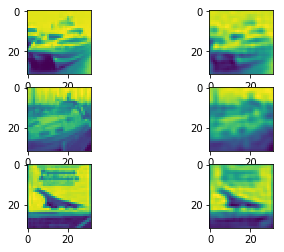

In [49]:
image_start = 1

# visualize the answer
img_0 = reshape_CIFAR(x[image_start+0])
img_0_hat = reshape_CIFAR(x_hat[image_start+0])

img_1 = reshape_CIFAR(x[image_start+1])
img_1_hat = reshape_CIFAR(x_hat[image_start+1])

img_2 = reshape_CIFAR(x[image_start+2])
img_2_hat = reshape_CIFAR(x_hat[image_start+2])

plt.subplot(321)
plt.imshow(img_0)

plt.subplot(322)
plt.imshow(img_0_hat)

plt.subplot(323)
plt.imshow(img_1)

plt.subplot(324)
plt.imshow(img_1_hat)

plt.subplot(325)
plt.imshow(img_2)

plt.subplot(326)
plt.imshow(img_2_hat)

plt.plot()

IndexError: index 100 is out of bounds for axis 0 with size 100

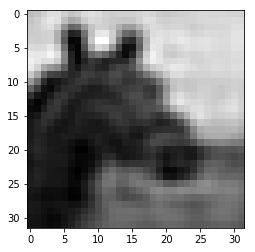

In [78]:
"""Comparisons"""
# x: 0; 
SAVE_PATH = 'ExperimentalResults/Reconstruction/MNIST_OS-ELA/'

for i in range(100):
    img_ = reshape_CIFAR(x[image_start+i])
    img_hat = reshape_CIFAR(x_hat[image_start+i])
    plt.imshow(img_, cmap='gray')
    plt.savefig(SAVE_PATH+str(i)+'.png')
    plt.imshow(img_hat, cmap='gray')
    plt.savefig(SAVE_PATH+str(i)+'_hat.png')

    

# Visualize the encoding layer

(1024, 256)
(256, 1024)


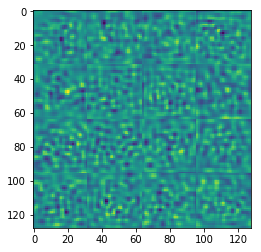

In [34]:
import math

alpha = auto_elm.retrieve_alpha()
print(alpha.shape)
alpha = np.transpose(alpha)
print(alpha.shape)

display_rows = 4
display_cols = 4

#img_height_width = int(math.sqrt(n_input_nodes/3)) # e.g., CIFAR10 32x32x3
img_height_width = int(math.sqrt(n_input_nodes)) # e.g., CIFAR10 32x32x3

#encoding_weights = np.zeros((display_rows*img_height_width, display_cols*img_height_width,3))
encoding_weights = np.zeros((display_rows*img_height_width, display_cols*img_height_width))
                             
for i in range(display_rows*display_cols):
    input_neuron_i_R = alpha[i,:1024]
    input_neuron_i_R_reshape = np.reshape(input_neuron_i_R, (img_height_width, img_height_width))
    encoding_weights[img_height_width*int(i/display_rows):img_height_width*int(i/display_rows)+img_height_width, img_height_width*int(i%display_rows):img_height_width*int(i%display_rows)+img_height_width] = input_neuron_i_R_reshape[:,:]
    '''
    encoding_weights[img_height_width*int(i/display_rows):img_height_width*int(i/display_rows)+img_height_width, img_height_width*int(i%display_rows):img_height_width*int(i%display_rows)+img_height_width,0] = input_neuron_i_R_reshape[:,:]
    input_neuron_i_G = alpha[i,1024:2048]
    input_neuron_i_G_reshape = np.reshape(input_neuron_i_G, (img_height_width, img_height_width))
    encoding_weights[img_height_width*int(i/display_rows):img_height_width*int(i/display_rows)+img_height_width, img_height_width*int(i%display_rows):img_height_width*int(i%display_rows)+img_height_width,1] = input_neuron_i_G_reshape[:,:]
    input_neuron_i_B = alpha[i,2048:3072]
    input_neuron_i_B_reshape = np.reshape(input_neuron_i_B, (img_height_width, img_height_width))
    encoding_weights[img_height_width*int(i/display_rows):img_height_width*int(i/display_rows)+img_height_width, img_height_width*int(i%display_rows):img_height_width*int(i%display_rows)+img_height_width,2] = input_neuron_i_B_reshape[:,:]
    '''
    
    
plt.imshow(10*encoding_weights)

# Visualize the decoding layer weights

(256, 1024)


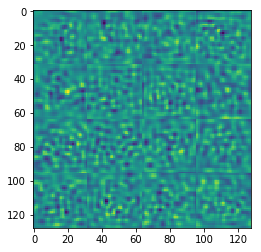

In [35]:
beta = auto_elm.retrieve_beta()
print(beta.shape)

display_rows = 4
display_cols = 4


#decoding_weights = np.zeros((display_rows*img_height_width, display_cols*img_height_width,3))
decoding_weights = np.zeros((display_rows*img_height_width, display_cols*img_height_width))


for i in range(display_rows*display_cols):
    input_neuron_i_R = beta[i,:1024]
    input_neuron_i_R_reshape = np.reshape(input_neuron_i_R, (img_height_width, img_height_width))
    decoding_weights[img_height_width*int(i/display_rows):img_height_width*int(i/display_rows)+img_height_width, img_height_width*int(i%display_rows):img_height_width*int(i%display_rows)+img_height_width] = input_neuron_i_R_reshape[:,:]
    '''
    decoding_weights[img_height_width*int(i/display_rows):img_height_width*int(i/display_rows)+img_height_width, img_height_width*int(i%display_rows):img_height_width*int(i%display_rows)+img_height_width,0] = input_neuron_i_R_reshape[:,:]
    input_neuron_i_G = beta[i,1024:2048]
    input_neuron_i_G_reshape = np.reshape(input_neuron_i_G, (img_height_width, img_height_width))
    decoding_weights[img_height_width*int(i/display_rows):img_height_width*int(i/display_rows)+img_height_width, img_height_width*int(i%display_rows):img_height_width*int(i%display_rows)+img_height_width,1] = input_neuron_i_G_reshape[:,:]
    input_neuron_i_B = beta[i,2048:3072]
    input_neuron_i_B_reshape = np.reshape(input_neuron_i_B, (img_height_width, img_height_width))
    decoding_weights[img_height_width*int(i/display_rows):img_height_width*int(i/display_rows)+img_height_width, img_height_width*int(i%display_rows):img_height_width*int(i%display_rows)+img_height_width,2] = input_neuron_i_B_reshape[:,:]
    '''
            
plt.imshow(10*decoding_weights)

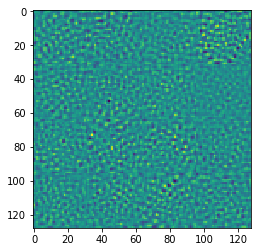

In [36]:
'''difference of encoding and decoding layer weights'''
plt.imshow(10*(encoding_weights - decoding_weights))

# OS-ELM Classification

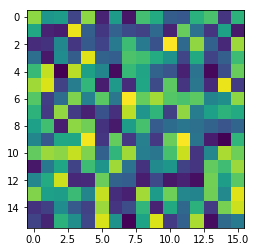

In [13]:
encoding = auto_elm.encoding(x_train[:10])
plt.imshow(np.reshape(encoding[0], [16,16]))
#encoding[0]

In [9]:
from os_elm import OS_ELM   # Huang's algorithm

n_input_nodes__ = 512
n_hidden_nodes__ = 64 
n_output_nodes__ = 10 # number of classes

def to_onehot(labels, classes):
    '''convert label to one-hot encoding'''
    ret = []
    eye = np.eye(classes)
    for y in labels:
        ret.append(eye[y])
    return np.array(ret)

n_classes = n_output_nodes__

border = 10000 # I manually changed this number

x_train_init = x_train[:border]
x_train_seq = x_train[border:]
y_train_init = y_train[:border]
y_train_seq = y_train[border:]

print('total initial: ', (border))
print('total sequential: ', len(x_train_seq))

y_train_init = to_onehot(y_train_init, n_classes)
y_train_seq = to_onehot(y_train_seq, n_classes)
y_test = to_onehot(y_test, n_classes)

total initial:  10000
total sequential:  40000


In [10]:
# ===========================================
# Instantiate os-elm
# ===========================================
os_elm = OS_ELM(
    # the number of input nodes.
    n_input_nodes=n_input_nodes__,
    # the number of hidden nodes.
    n_hidden_nodes=n_hidden_nodes__,
    # the number of output nodes.
    n_output_nodes=n_output_nodes__,
    # loss function.
    # the default value is 'mean_squared_error'.
    # for the other functions, we support
    # 'mean_absolute_error', 'categorical_crossentropy', and 'binary_crossentropy'.
    loss='mean_squared_error',
    # activation function applied to the hidden nodes.
    # the default value is 'sigmoid'.
    # for the other functions, we support 'linear' and 'tanh'.
    # NOTE: OS-ELM can apply an activation function only to the hidden nodes.
    activation='sigmoid',
    name='OS_ELM'
)

In [11]:
# the initial training phase
os_elm.init_train(auto_elm.encoding(x_train_init), y_train_init)

'''initial training evaluation'''
[train_loss, train_accuracy] = os_elm.evaluate(auto_elm.encoding(x_train[:len(x_test)]), y_test[:len(x_test)], metrics=['loss', 'accuracy'])
[test_loss, test_accuracy] = os_elm.evaluate(auto_elm.encoding(x_test), y_test, metrics=['loss', 'accuracy'])
print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    
epoch_train_loss__ = []
epoch_test_loss__ = []
#epoch_train_loss.append(train_loss)
#epoch_test_loss.append(test_loss)

train_loss: 4.024244, train_accuracy: 0.100600
test_loss: 4.024067, test_accuracy: 0.095100


In [12]:
# the sequential training phase
batch_size = 4096

for epoch in range(30):
    pbar = tqdm(total=len(x_train), desc='sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        os_elm.seq_train(auto_elm.encoding(x_batch), y_batch)
        pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = os_elm.evaluate(auto_elm.encoding(x_train[:len(x_test)]), y_test[:len(x_test)], metrics=['loss', 'accuracy'])
    [test_loss, test_accuracy] = os_elm.evaluate(auto_elm.encoding(x_test), y_test, metrics=['loss', 'accuracy'])
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_loss__.append(train_loss)
    epoch_test_loss__.append(test_loss)

    pbar.close()
    
'''plot loss curve'''
import matplotlib.pyplot as plt
plt.plot(epoch_train_loss__)
plt.plot(epoch_test_loss__)
plt.title('loss curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

train_loss: 10207276032.000000, train_accuracy: 0.100000
test_loss: 10226836480.000000, test_accuracy: 0.100000



train_loss: 30875819442176.000000, train_accuracy: 0.100000
test_loss: 30866539544576.000000, test_accuracy: 0.100000



train_loss: 4449450852352.000000, train_accuracy: 0.100900
test_loss: 4447795150848.000000, test_accuracy: 0.096700



train_loss: 6149067096719360.000000, train_accuracy: 0.100000
test_loss: 6149137426808832.000000, test_accuracy: 0.100000



train_loss: 2157680132096.000000, train_accuracy: 0.101800
test_loss: 2120640495616.000000, test_accuracy: 0.099900



train_loss: 2984948269056.000000, train_accuracy: 0.099900
test_loss: 2951424507904.000000, test_accuracy: 0.099100



train_loss: 21898051819929600.000000, train_accuracy: 0.100000
test_loss: 21894867101679616.000000, test_accuracy: 0.100000



train_loss: 77046491709519691776.000000, train_accuracy: 0.100000
test_loss: 77053317477704925184.000000, test_accuracy: 0.100000



train_loss: 276114035829422237417472.000000, train_accuracy: 0.100000
test_loss: 276107982991523051470848.000000, test_accuracy: 0.100000



train_loss: 673599388134194321016487936.000000, train_accuracy: 0.100000
test_loss: 673501694177579955231129600.000000, test_accuracy: 0.100000



train_loss: 10574199718008108870332263170048.000000, train_accuracy: 0.100000
test_loss: 10578388645973073560422620069888.000000, test_accuracy: 0.100000



train_loss: inf, train_accuracy: 0.100000
test_loss: inf, test_accuracy: 0.100000



train_loss: inf, train_accuracy: 0.100000
test_loss: inf, test_accuracy: 0.100000



KeyboardInterrupt: 